# Load Dataset + EDA + Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import pickle

DATA_PATH = r"C:\Users\sachi\Fake_News_Detection\Data_Set\IFND.csv"

df = pd.read_csv(DATA_PATH, encoding="latin1")

print("Shape:", df.shape)
df.head()


C:\Users\sachi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Shape: (56714, 7)


,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE


Label distribution plot

Label
TRUE    37800
Fake    18914
Name: count, dtype: int64


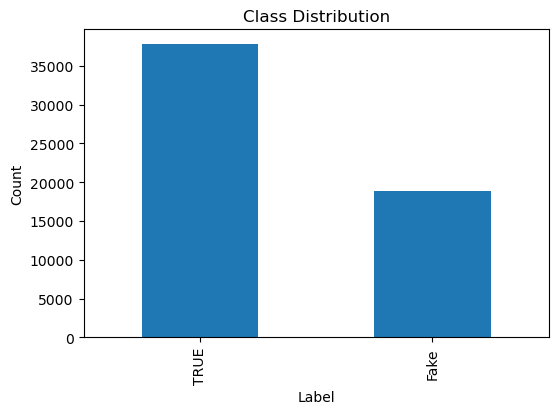

In [2]:
df['Label'] = df['Label'].astype(str).str.strip()

print(df['Label'].value_counts())

plt.figure(figsize=(6,4))
df['Label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# Text Cleaning Function

In [3]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z\u0900-\u097F ]", " ", text)   # English + Hindi support
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["Statement"].apply(clean_text)

df[["Statement","clean_text"]].head()


,Statement,clean_text
0,"WHO praises India's Aarogya Setu app, says it ...",who praises india s aarogya setu app says it h...
1,"In Delhi, Deputy US Secretary of State Stephen...",in delhi deputy us secretary of state stephen ...
2,LAC tensions: China's strategy behind delibera...,lac tensions china s strategy behind deliberat...
3,India has signed 250 documents on Space cooper...,india has signed documents on space cooperatio...
4,Tamil Nadu chief minister's mother passes away...,tamil nadu chief minister s mother passes away at


# TF-IDF Vectorizer + Train-Test Split

In [4]:
df["Label"].isna().sum()


0

In [5]:
df["Label"].value_counts()


Label
TRUE    37800
Fake    18914
Name: count, dtype: int64

In [6]:
df["Label"] = df["Label"].astype(str).str.strip().str.title()
df["Label"].value_counts()


Label
True    37800
Fake    18914
Name: count, dtype: int64

In [7]:
df["Label_num"] = df["Label"].map({"Fake":0, "True":1})
df["Label_num"].isna().sum()


0

In [8]:
# ================================================================
# TF-IDF Vectorizer + Train-Test Split
# ================================================================

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

df["Label_num"] = df["Label"].map({"Fake":0, "True":1})

X = df["clean_text"]
y = df["Label_num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=20000, stop_words="english", ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((45371, 20000), (11343, 20000))

# Train All Models

In [13]:
# ================================================================
# Train All Models
# ================================================================

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# All models combined
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC(dual="auto"),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000)
}

results = {}
trained_models = {}   # <-- YE IMPORTANT HAI

print("============ Training Started ============\n")

for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train_tfidf, y_train)

    trained_models[name] = model   # <-- model ko store karna zaroori hai

    pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc}\n")

print("============ Training Completed ============")
print(results)


============ Training Started ============

Training Logistic Regression ...
Logistic Regression Accuracy: 0.9451644185841488

Training Naive Bayes ...
Naive Bayes Accuracy: 0.9434012166093626

Training SVM (LinearSVC) ...
SVM (LinearSVC) Accuracy: 0.9522172264832937

Training Decision Tree ...
Decision Tree Accuracy: 0.9314114431808164

Training Random Forest ...
Random Forest Accuracy: 0.9515119456933792

Training Passive Aggressive ...
Passive Aggressive Accuracy: 0.9362602486114785

============ Training Completed ============
{'Logistic Regression': 0.9451644185841488, 'Naive Bayes': 0.9434012166093626, 'SVM (LinearSVC)': 0.9522172264832937, 'Decision Tree': 0.9314114431808164, 'Random Forest': 0.9515119456933792, 'Passive Aggressive': 0.9362602486114785}


# Select Best Model

In [14]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

for name, model in trained_models.items():
    pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc}")
    print(classification_report(y_test, pred))

best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]

print("\nBest Model:", best_model_name)



Logistic Regression Accuracy: 0.9451644185841488
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3783
           1       0.93      0.99      0.96      7560

    accuracy                           0.95     11343
   macro avg       0.96      0.92      0.94     11343
weighted avg       0.95      0.95      0.94     11343


Naive Bayes Accuracy: 0.9434012166093626
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      3783
           1       0.93      0.98      0.96      7560

    accuracy                           0.94     11343
   macro avg       0.95      0.92      0.93     11343
weighted avg       0.94      0.94      0.94     11343


SVM (LinearSVC) Accuracy: 0.9522172264832937
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3783
           1       0.95      0.98      0.96      7560

    accuracy                           0.95 

# Prediction Function (Fake / True)

In [16]:
!pip install deep-translator


  Obtaining dependency information for deep-translator from https://files.pythonhosted.org/packages/38/3f/61a8ef73236dbea83a1a063a8af2f8e1e41a0df64f122233938391d0f175/deep_translator-1.11.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
   -------------------------------------- - 41.0/42.3 kB ? eta -:--:--
   ---------------------------------------- 42.3/42.3 kB 2.0 MB/s eta 0:00:00


In [27]:
# ================================================================
# SECTION — PREDICTION FUNCTION (With Translation + User Input)
# ================================================================

from deep_translator import GoogleTranslator

# 1. Auto-translation function
def translate_to_english(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        return text

# 2. Final prediction function
def predict_news(text, model, vectorizer):
    
    # Step 1: Translate to English
    translated = translate_to_english(text)

    # Step 2: Clean text
    cleaned = clean_text(translated)

    # Step 3: Vectorize
    x_vec = vectorizer.transform([cleaned])

    # Step 4: Predict
    pred = model.predict(x_vec)[0]

    result = "🟢 TRUE NEWS" if pred == 1 else "🔴 FAKE NEWS"

    return result, translated, cleaned

# 3. User Input + Prediction
print("Enter any news text (any language): ")
user_text = input()

result, translated, cleaned = predict_news(
    user_text,
    best_model,    # <- aapka selected best model
    tfidf          # <- aapka trained TF-IDF vectorizer
)

print("\n--- RESULT ---")
print("Prediction:", result)
print("Translated:", translated)
print("Cleaned:", cleaned)


Enter any news text (any language): 
સેના કહે છે કે ઉત્તર પૂર્વમાં ફેલાતા ખોટા સમાચારોથી સાવધ રહો

--- RESULT ---
Prediction: 🔴 FAKE NEWS
Translated: Army says to beware of fake news spreading in North East
Cleaned: army says to beware of fake news spreading in north east


# Save Model + Vectorizer (Pickle)

In [24]:
pickle.dump(best_model, open("news_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))
